In [6]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Lectura de datos originales

In [2]:
data_folder_name = 'dl-itba-cifar-100-2024-q-1'

def getFileNames(folder_name):
    
    path = os.path.join(os.getcwd(),'..','..',folder_name)
    file_names = os.listdir(path)

    return file_names 

print(getFileNames(data_folder_name))

['coarse_label_names.pck', 'fine_label_names.pck', 'x_test.npy', 'x_train.npy', 'y_train_coarse.npy', 'y_train_fine.npy']


In [3]:
file_names = getFileNames(data_folder_name)

# Lectura de archivos '.npy' 

x_test = np.load('../'+'../'+data_folder_name+'/'+file_names[2])
x_train = np.load('../'+'../'+data_folder_name+'/'+file_names[3])
y_train_coarse = np.load('../'+'../'+data_folder_name+'/'+file_names[4])
y_train_fine = np.load('../'+'../'+data_folder_name+'/'+file_names[5])

# Lectura de archivos '.pck'

with open('../'+'../'+data_folder_name+'/'+file_names[0], "rb") as f:
    coarse_label_names = pickle.load(f)
f.close()

with open('../'+'../'+data_folder_name+'/'+file_names[1], "rb") as f:
    fine_label_names = pickle.load(f)
f.close()

print('Dimensiones de los datos:')
print(x_test.shape)
print(x_train.shape)
print(y_train_coarse.shape)
print(y_train_fine.shape)

print('Cantidad de clases:')
print(np.shape(coarse_label_names))
print(np.shape(fine_label_names))

Dimensiones de los datos:
(10000, 32, 32, 3)
(50000, 32, 32, 3)
(50000,)
(50000,)
Cantidad de clases:
(20,)
(100,)


Se lleva a cabo la unión de labels, con el objetivo de repartirlos según la imagen que correspondan.

In [5]:
# Unión de labels 'fine' y 'coarse'

y_train_union = np.array([[i,j] for i,j in zip(y_train_fine, y_train_coarse)])
print(y_train_union.shape)

(50000, 2)


### Selección de un subgrupo de datos de train para trabajar adecuadamente

El train original es dividido en 80% datos de train, y 20% datos de validación.

In [8]:
x_sub_train, x_sub_val, y_sub_train, y_sub_val = train_test_split(x_train, y_train_union, test_size=0.2, stratify=y_train_union)

print(f'Dimensiones de x_sub_train: {x_sub_train.shape}')
print(f'Dimensiones de x_sub_val:   {x_sub_val.shape}')
print(f'Dimensiones de y_sub_train: {y_sub_train.shape}')
print(f'Dimensiones de y_sub_val:   {y_sub_val.shape}')

Dimensiones de x_sub_train: (40000, 32, 32, 3)
Dimensiones de x_sub_val:   (10000, 32, 32, 3)
Dimensiones de y_sub_train: (40000, 2)
Dimensiones de y_sub_val:   (10000, 2)


### Data Augmentation de los datos 'x_sub_train' y 'y_sub_train'

La intención es aumentar la cantidad de datos originales de 'x_sub_train'. A su vez, se deben generar los correspondientes vectores de etiquetas.

In [10]:
def dataAugmentation4Img(img,num_new_data):
    
    """
    Devuelve un array de '1+num_new_data' imágenes, siendo el primer elemento la imagen original.
    """
    
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        brightness_range=[0.3,1.5])
    
    img = img.reshape((1,) + img.shape)
    
    augmented_images = np.array(np.uint8([batch[0] for batch, iter in zip(datagen.flow(img, batch_size=1),np.arange(num_new_data))]))
    
    augmented_images = np.concatenate((img, augmented_images), axis=0)
    
    return augmented_images

def labels4dataAugmentation4Img(img_label,num_new_data):
    
    """
    Devuelve un array de '1+num_new_data' labels, siendo el primer elemento el label de la imagen original.
    """
    
    augmented_labels = np.array([img_label for i in np.arange(num_new_data+1)])
    
    return augmented_labels

def dataAugmentation4ImgBatch(img_batch,img_labels,num_new_data):
    
    """
    Devuelve los vectores de data aumentada y los vectores de etiquetas.
    """
    
    # Creación de/del vector/vectores de labels
    
    labels = []
    
    for i in range(len(img_labels)):
        
        list_labels_4_img = np.array([labels4dataAugmentation4Img(img_label,num_new_data) for img_label in img_labels[i]])
        
        list_labels_4_img = np.hstack(list_labels_4_img)
        
        labels.append(list_labels_4_img)      
        
    # Creación del vector de imágenes
    
    list_new_data_4_img = np.array([dataAugmentation4Img(img,num_new_data) for img in img_batch])
    
    stack_imgs = np.concatenate(list_new_data_4_img,axis=0)
    
    return stack_imgs, labels

In [11]:
def saveNpyData(arr_x,arr_y_list,name_extern_folder='carpeta',type='tipo'):
    
    path_extern_folder = os.path.join(os.getcwd(), '..', '..', name_extern_folder)

    if not os.path.exists(path_extern_folder):
        os.makedirs(path_extern_folder)

    # Guardado de labels
    for i in range(len(arr_y_list)):
        np.save(os.path.join(path_extern_folder, f'y_{type}_{i}.npy'), arr_y_list[i])
    
    # Guardado de imgs
    np.save(os.path.join(path_extern_folder, f'x_{type}.npy'), arr_x)

Con las funciones anteriores, se lleva el data augmentation y se guardan los archivos para su futuro uso.

Se crearán 25 imágenes nuevas para cada imagen original.

In [18]:
y_sub_train_fine    = y_sub_train[:,0]
y_sub_train_coarse  = y_sub_train[:,1]

x_sub_train_aug, y_sub_train_aug = dataAugmentation4ImgBatch(x_sub_train,[y_sub_train_fine,y_sub_train_coarse],num_new_data=25)

In [19]:
y_sub_val_fine      = y_sub_val[:,0]
y_sub_val_coarse    = y_sub_val[:,1]

saveNpyData(x_sub_train_aug,y_sub_train_aug,name_extern_folder='dataSelected',type='sub_train_aug')
saveNpyData(x_sub_val,[y_sub_val_fine,y_sub_val_coarse],name_extern_folder='dataSelected',type='sub_val')


### Visualización de datos generados

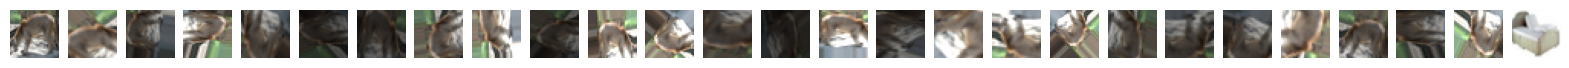

[42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42 42
 42 42  5]
[8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 6]


In [22]:
fig = plt.figure(figsize=(20,5))
for i, img in enumerate(x_sub_train_aug[:27]):
    ax = fig.add_subplot(1, len(x_sub_train_aug[:27]), i+1)
    ax.imshow(img)
    ax.axis('off')
plt.show()

print(y_sub_train_aug[0][:27])
print(y_sub_train_aug[1][:27])